In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 한글 폰트 설정(Windows)
plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)

# 그래프 표시용 한글 라벨
label_map = {
    "year": "연도",
    "country": "국가",
    "rank": "순위",
    "score": "행복지수",
    "gdp_per_capita": "1인당 GDP",
    "social_support": "사회적 지지",
    "healthy_life_expectancy": "건강 기대수명",
    "freedom": "선택의 자유",
    "generosity": "관대함",
    "corruption": "부패 인식",
}

def klabel(col_name: str) -> str:
    """
    표준 컬럼명을 시각화용 한글 라벨로 변환합니다.

    Parameters
    ----------
    col_name : str
        표준 스키마에서 사용하는 컬럼명입니다.

    Returns
    -------
    str
        그래프 제목/축 라벨에 사용할 표시 문자열을 반환합니다.
        매핑이 없으면 원본 컬럼명을 그대로 반환합니다.
    """
    return label_map.get(col_name, col_name)

0) 데이터 로드

In [3]:
happiness_df = pd.read_csv("../data/happiness_2015_2024.csv")

# 기본 확인: 행/열, 컬럼 목록, 앞부분 샘플
print("shape:", happiness_df.shape)
print("columns:", happiness_df.columns.tolist())
happiness_df.head()

shape: (1510, 10)
columns: ['year', 'country', 'rank', 'score', 'gdp_per_capita', 'social_support', 'healthy_life_expectancy', 'freedom', 'generosity', 'corruption']


,year,country,rank,score,gdp_per_capita,social_support,healthy_life_expectancy,freedom,generosity,corruption
0,2015,Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978
1,2015,Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145
2,2015,Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357
3,2015,Norway,4,7.522,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503
4,2015,Canada,5,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957


1) 프로젝트 개요

목적: 2015~2024 세계 행복지수(score)와 연관 지표 간 관계를 탐색하고, 행복지수 개선에 영향을 줄 수 있는 핵심 요인을 파악한다.

출처: Kaggle – World Happiness Report (2015~2024)

데이터: 연도별 국가 단위 행복지수와 주요 요인 지표(경제, 사회적 지원, 기대수명, 자유, 관대함, 부패 인식 등)

2) 데이터 기본 정보

In [4]:
# 컬럼별 타입 확인: 범주형/수치형을 나누기 위한 기본 단계
basic_info_df = pd.DataFrame({
    "column": happiness_df.columns,
    "dtype": [str(t) for t in happiness_df.dtypes]
})
basic_info_df

,column,dtype
0,year,int64
1,country,str
2,rank,int64
3,score,float64
4,gdp_per_capita,float64
5,social_support,float64
6,healthy_life_expectancy,float64
7,freedom,float64
8,generosity,float64
9,corruption,float64


In [5]:
# 결측치 요약: 컬럼별 결측 개수와 비율을 함께 본다.
missing_summary_df = (
    happiness_df.isna()
    .sum()
    .to_frame("missing_count")
    .assign(missing_ratio=lambda x: (x["missing_count"] / len(happiness_df)).round(4))
    .sort_values("missing_count", ascending=False)
)
missing_summary_df

,missing_count,missing_ratio
healthy_life_expectancy,4,0.0026
corruption,4,0.0026
freedom,3,0.0020
generosity,3,0.0020
social_support,3,0.0020
gdp_per_capita,3,0.0020
country,0,0.0000
year,0,0.0000
rank,0,0.0000
score,0,0.0000


In [6]:
# 연도별 데이터 분포: 연도마다 국가 수/행 수 차이가 있는지 확인
year_summary_df = (
    happiness_df.groupby("year")
    .agg(rows=("country", "size"), unique_countries=("country", "unique"))
    .reset_index()
    .sort_values("year")
)
year_summary_df

,year,rows,unique_countries
0,2015,158,"[Switzerland, Iceland, Denmark, Norway, Canada..."
1,2016,157,"[Denmark, Switzerland, Iceland, Norway, Finlan..."
2,2017,155,"[Norway, Denmark, Iceland, Switzerland, Finlan..."
3,2018,156,"[Finland, Norway, Denmark, Iceland, Switzerlan..."
4,2019,156,"[Finland, Denmark, Norway, Iceland, Netherland..."
5,2020,153,"[Finland, Denmark, Switzerland, Iceland, Norwa..."
6,2021,149,"[Finland, Denmark, Switzerland, Iceland, Nethe..."
7,2022,146,"[Finland, Denmark, Iceland, Switzerland, Nethe..."
8,2023,137,"[Finland, Denmark, Iceland, Israel, Netherland..."
9,2024,143,"[Finland, Denmark, Iceland, Sweden, Israel, Ne..."


3) 기술 통계 요약

In [7]:
# 수치형 컬럼만 묶어서 describe 요약을 본다.
numeric_cols = [
    "rank", "score",
    "gdp_per_capita", "social_support", "healthy_life_expectancy",
    "freedom", "generosity", "corruption"
]

# 타입이 섞여 있으면 분석이 꼬일 수 있어서 numeric으로 강제 변환(문자면 NaN 처리)
for col in numeric_cols:
    happiness_df[col] = pd.to_numeric(happiness_df[col], errors="coerce")

happiness_df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
rank,1510.0,76.144371,43.850630,1.000,38.000000,76.000000,114.000000,158.000000
score,1510.0,5.449274,1.122885,1.721,4.603500,5.472000,6.269000,7.842000
gdp_per_capita,1507.0,1.052821,0.462911,0.000,0.740685,1.070000,1.373500,2.209000
social_support,1507.0,1.053570,0.332261,0.000,0.841210,1.093000,1.318130,1.644000
healthy_life_expectancy,1506.0,0.578193,0.239482,0.000,0.401490,0.602185,0.760000,1.141000
freedom,1507.0,0.466545,0.164760,0.000,0.367075,0.481810,0.585300,0.863000
generosity,1507.0,0.191633,0.111113,0.000,0.112000,0.177000,0.248041,0.838075
corruption,1506.0,0.134292,0.114028,0.000,0.058098,0.100000,0.171000,0.587000


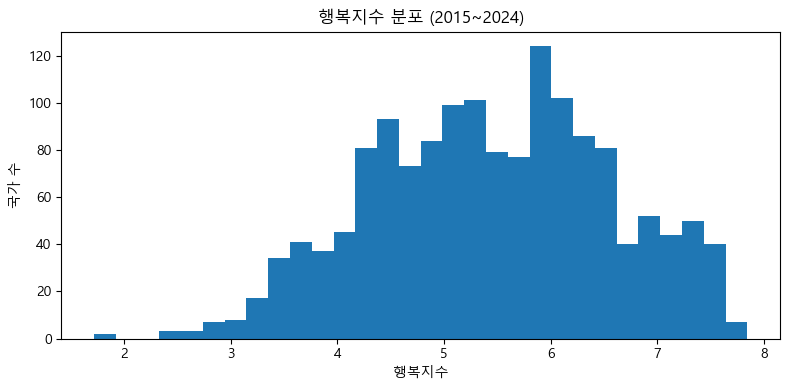

In [8]:
# score 분포: 전체 데이터가 어떤 범위에 몰려있는지 감 잡기
plt.figure(figsize=(8,4))
plt.hist(happiness_df["score"].dropna(), bins=30)
plt.title("행복지수 분포 (2015~2024)")
plt.xlabel(klabel("score"))
plt.ylabel("국가 수")
plt.tight_layout()
plt.show()

기술 통계 확인 결과, 행복지수(score)는 국가별로 분포가 넓게 퍼져 있으며 연도 전체 기준으로도 일정한 변동폭이 존재한다.

지표들 간 스케일이 서로 달라(score는 0 ~ 10대, 나머지 지표는 0 ~ 2 수준) 단순 값 비교보다는 관계(상관/추세) 중심으로 해석하는 것이 적절하다.

4) 결측치 및 이상치 탐색

In [9]:
# score 이상치: IQR 기준으로 너무 낮거나 높은 값이 있는지 확인
q1 = happiness_df["score"].quantile(0.25)
q3 = happiness_df["score"].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outlier_df = happiness_df[(happiness_df["score"] < lower) | (happiness_df["score"] > upper)]
print("outliers:", len(outlier_df))
outlier_df[["year", "country", "score"]].sort_values(["year", "score"]).head(20)

outliers: 2


,year,country,score
1366,2023,Afghanistan,1.859
1509,2024,Afghanistan,1.721


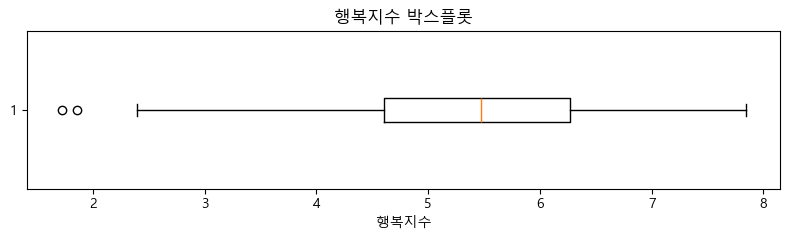

In [10]:
# boxplot으로 분포/이상치 위치를 직관적으로 확인
plt.figure(figsize=(8,2.5))
plt.boxplot(happiness_df["score"].dropna(), vert=False)
plt.title("행복지수 박스플롯")
plt.xlabel(klabel("score"))
plt.tight_layout()
plt.show()

결측치는 전체적으로 매우 적었다.

결측 상위 3개 컬럼은 healthy_life_expectancy(4건, 0.0026), corruption(4건, 0.0026), freedom(3건, 0.0020)이며, 분석 결과에 큰 영향을 주는 수준은 아니다.

이상치는 IQR/boxplot 기준으로 일부 관측치가 확인되지만, 국가 단위 지표 특성상 실제 값일 가능성이 높아 우선 제거하지 않고 참고 케이스로 유지한다.

5) 변수 간 관계 분석

In [11]:
# 수치형 변수 간 상관계수: score와 연관이 큰 지표가 뭔지 빠르게 보기
corr_df = happiness_df[numeric_cols].corr()
corr_df["score"].sort_values(ascending=False)

score                      1.000000
gdp_per_capita             0.713724
healthy_life_expectancy    0.679125
social_support             0.663865
freedom                    0.557326
corruption                 0.419513
generosity                 0.081295
rank                      -0.985148
Name: score, dtype: float64

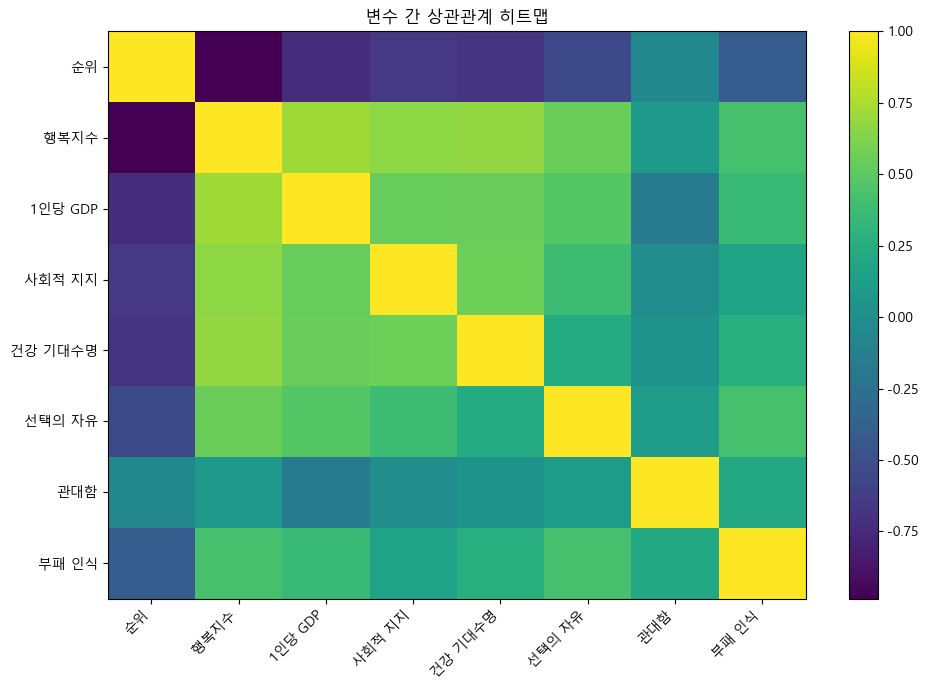

In [12]:
# heatmap: 상관관계를 한 번에 보기 (matplotlib만 사용)
numeric_cols = [
    "rank", "score",
    "gdp_per_capita", "social_support", "healthy_life_expectancy",
    "freedom", "generosity", "corruption"
]

# 숫자 타입 강제(문자 섞이면 NaN 처리)
for col in numeric_cols:
    happiness_df[col] = pd.to_numeric(happiness_df[col], errors="coerce")

corr_df = happiness_df[numeric_cols].corr()

plt.figure(figsize=(10,7))
plt.imshow(corr_df, aspect="auto")
plt.xticks(
    range(len(corr_df.columns)),
    [klabel(c) for c in corr_df.columns],
    rotation=45, ha="right"
)
plt.yticks(
    range(len(corr_df.index)),
    [klabel(c) for c in corr_df.index]
)
plt.colorbar()
plt.title("변수 간 상관관계 히트맵")
plt.tight_layout()
plt.show()

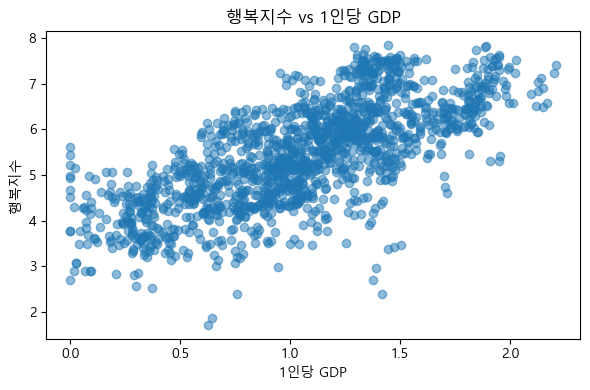

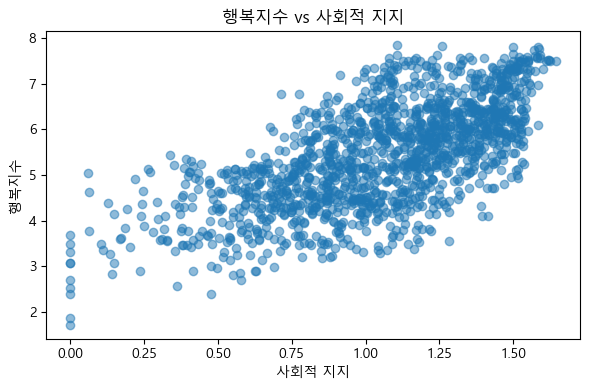

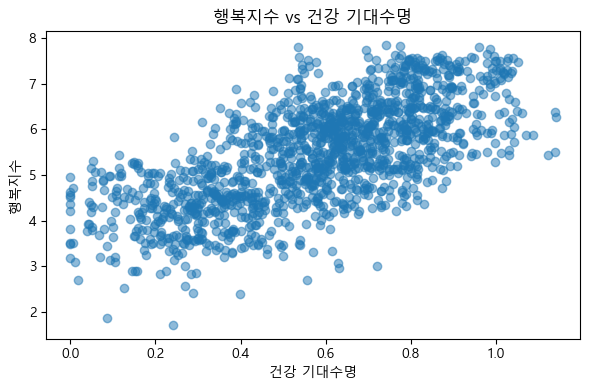

In [13]:
# score와 주요 지표 산점도: 상관이 실제로 어떤 형태인지(선형/비선형/산포) 확인
def scatter_plot(x_col: str):
    """
    지정한 지표(x_col)와 점수(y_col)의 관계를 산점도로 시각화합니다.

    Parameters
    ----------
    df : pd.DataFrame
        산점도를 그릴 데이터프레임입니다. x_col, y_col을 포함해야 합니다.
    x_col : str
        x축에 사용할 컬럼명입니다.
    y_col : str, default="score"
        y축에 사용할 컬럼명입니다.

    Returns
    -------
    None
        산점도를 화면에 출력합니다.
    """
    plt.figure(figsize=(6,4))
    plt.scatter(happiness_df[x_col], happiness_df["score"], alpha=0.5)
    plt.title(f"{klabel('score')} vs {klabel(x_col)}")
    plt.xlabel(klabel(x_col))
    plt.ylabel(klabel("score"))
    plt.tight_layout()
    plt.show()

for col in ["gdp_per_capita", "social_support", "healthy_life_expectancy"]:
    scatter_plot(col)

상관 분석 결과, 행복지수(score)와 가장 연관이 큰 변수는 gdp_per_capita(0.714), healthy_life_expectancy(0.679), social_support(0.664) 순이었다.

즉, 경제 수준, 건강 기대수명, 사회적 지지 수준이 높을수록 행복지수가 함께 높아지는 경향이 뚜렷했다.

다만 산점도에서 완전히 직선 형태만 나타나는 것은 아니므로, 단일 변수로 설명하기보다 여러 변수를 함께 고려하는 접근이 필요하다.

6) 파생 변수 및 전처리 제안

In [14]:
# 연도별 평균 score: 시간이 지남에 따라 평균 행복지수가 변하는지 확인
year_score_df = (
    happiness_df.groupby("year")["score"]
    .mean()
    .reset_index()
    .sort_values("year")
)
year_score_df["yoy_change"] = year_score_df["score"].diff()
year_score_df

,year,score,yoy_change
0,2015,5.375734,NaN
1,2016,5.382185,0.006451
2,2017,5.354019,-0.028165
3,2018,5.375917,0.021897
4,2019,5.407096,0.031179
5,2020,5.473203,0.066106
6,2021,5.532839,0.059636
7,2022,5.553575,0.020736
8,2023,5.539796,-0.013780
9,2024,5.527580,-0.012215


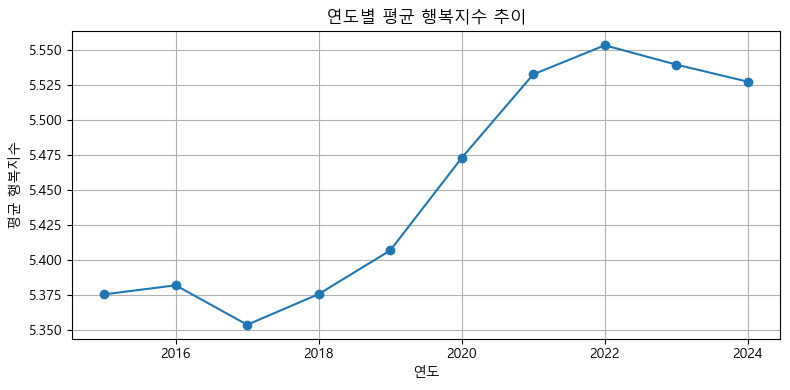

In [15]:
# 연도별 평균 score 추이 시각화
year_score_df = (
    happiness_df.groupby("year")["score"]
    .mean()
    .reset_index()
    .sort_values("year")
)
year_score_df["yoy_change"] = year_score_df["score"].diff()

plt.figure(figsize=(8,4))
plt.plot(year_score_df["year"], year_score_df["score"], marker="o")
plt.title("연도별 평균 행복지수 추이")
plt.xlabel(klabel("year"))
plt.ylabel("평균 행복지수")
plt.grid(True)
plt.tight_layout()
plt.show()

결측치는 규모가 작아 분석 목적에 따라 행 제거 또는 간단 대체(중앙값)로 처리 가능하다.

연도 효과가 존재할 수 있으므로 year를 통제하거나, 연도별 평균/변화량(yoy)을 함께 보는 방식이 유용하다.

국가명 표기 차이가 있다면 정규화하여 연도별 추적이 가능하게 한다.

지표별 스케일 차이가 있으므로 거리 기반 분석/모델링 전 표준화 적용을 고려한다.

파생 변수로 국가별 장기 평균 score, 변동성(표준편차), 전년 대비 변화량 등을 생성하면 추세 비교가 쉬워진다.

7) 요약 및 인사이트

2015~2024 데이터를 통합해 분포, 결측/이상치, 변수 관계를 탐색했다.

결측치는 매우 적어(상위 컬럼도 0.3% 미만) 데이터 품질은 전반적으로 양호했다.

행복지수는 gdp_per_capita, healthy_life_expectancy, social_support와 높은 양의 상관을 보여 핵심 설명 변수 후보로 적합하다.

연도별 평균 행복지수는 2015 대비 2024에 약 +0.152 상승해 장기적으로 소폭 증가 경향을 보였다.

다음 단계로, 주요 변수 기반 회귀/트리 모델을 적용해 변수 중요도를 확인하고, 국가별 변화 추세(상승/하락 국가)까지 확장 분석할 수 있다.